# Data Processing

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout, Masking, Input


In [2]:
def load_images_and_labels(image_folder, labels_file, target_size=(224, 224)):
    labels_df = pd.read_csv(labels_file)
    labels_df['labels'] = labels_df['labels'].apply(eval)  # Convert string representation of list to actual list

    images = []
    pitch_labels = []
    duration_labels = []

    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        image = Image.open(img_path).convert('RGB')
        image = image.resize(target_size)
        image = img_to_array(image)
        images.append(image)

        pitches = [label[0] for label in row['labels']]
        durations = [label[1] for label in row['labels']]
        pitch_labels.append(pitches)
        duration_labels.append(durations)

    return np.array(images), pitch_labels, duration_labels

# Load data
image_folder = '../raw_data/sheet_images'
labels_file = '../raw_data/labels.csv'
images, pitch_labels, duration_labels = load_images_and_labels(image_folder, labels_file)

# Normalize the images
images = images / 255.0


# Encode

In [4]:
# Encode labels
pitch_encoder = LabelEncoder()
duration_encoder = LabelEncoder()

# Flatten the pitch and duration labels correctly
flat_pitch_labels = [item for sublist in pitch_labels for item in sublist]
flat_duration_labels = [item for sublist in duration_labels for item in sublist]

# Fit encoders and transform labels
encoded_pitches = pitch_encoder.fit_transform(flat_pitch_labels)
encoded_durations = duration_encoder.fit_transform(flat_duration_labels)

# Reshape back into sequences
pitch_labels = np.array(np.split(encoded_pitches, len(pitch_labels)))
duration_labels = np.array(np.split(encoded_durations, len(duration_labels)))

# One-hot encode labels
pitch_labels = [to_categorical(seq, num_classes=len(pitch_encoder.classes_)) for seq in pitch_labels]
duration_labels = [to_categorical(seq, num_classes=len(duration_encoder.classes_)) for seq in duration_labels]

def pad_images(images, max_sequence_length, target_size=(224, 224, 3)):
    padded_images = []
    for img_seq in images:
        # Create an array of zeros with the desired max_sequence_length
        padded_seq = np.zeros((max_sequence_length, *target_size), dtype=np.float32)
        # Fill the padded_seq with the actual images
        padded_seq[:len(img_seq)] = img_seq
        padded_images.append(padded_seq)
    return np.array(padded_images)

max_sequence_length = max(len(seq) for seq in pitch_labels)

# Pad the images manually
padded_images = pad_images(images, max_sequence_length, target_size=(224, 224, 3))

# Pad the pitch and duration labels to match the max_sequence_length
padded_pitch_labels = pad_sequences(pitch_labels, maxlen=max_sequence_length, padding='post')
padded_duration_labels = pad_sequences(duration_labels, maxlen=max_sequence_length, padding='post')


# Model Architecture

In [5]:
#CNN

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Input, Masking
from tensorflow.keras.models import Model

def create_custom_cnn(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    cnn_model = Model(inputs, x)

    return cnn_model


In [7]:
#Sequence

def create_sequence_model(cnn_model, max_sequence_length, num_pitch_classes, num_duration_classes):
    inputs = Input(shape=(max_sequence_length, 224, 224, 3))

    x = TimeDistributed(cnn_model)(inputs)
    x = Masking(mask_value=0.0)(x)  # Mask out the padded values
    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    pitch_output = TimeDistributed(Dense(num_pitch_classes, activation='softmax'), name='pitch_output')(x)
    duration_output = TimeDistributed(Dense(num_duration_classes, activation='softmax'), name='duration_output')(x)

    model = Model(inputs, [pitch_output, duration_output])
    return model

In [9]:
# Instantiate the model
input_shape = (224, 224, 3)  # Image dimensions
num_pitch_classes = len(pitch_encoder.classes_)
num_duration_classes = len(duration_encoder.classes_)

cnn_model = create_custom_cnn(input_shape)
model = create_sequence_model(cnn_model, max_sequence_length, num_pitch_classes, num_duration_classes)


# Compile and Train

In [10]:
# Compile the model (if not already done)
model.compile(
    optimizer='adam',
    loss={'pitch_output': 'categorical_crossentropy', 'duration_output': 'categorical_crossentropy'},
    metrics={'pitch_output': 'accuracy', 'duration_output': 'accuracy'}
)

In [11]:
# Train the model
history = model.fit(
    padded_images,
    {'pitch_output': padded_pitch_labels, 'duration_output': padded_duration_labels},
    epochs=20,
    batch_size=4,
    validation_split=0.2
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 624s 30s/step - duration_output_accuracy: 0.2940 - loss: 4.8512 - pitch_output_accuracy: 0.0620 - val_duration_output_accuracy: 0.3503 - val_loss: 4.2827 - val_pitch_output_accuracy: 0.0580
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 594s 30s/step - duration_output_accuracy: 0.3498 - loss: 4.3075 - pitch_output_accuracy: 0.0572 - val_duration_output_accuracy: 0.3503 - val_loss: 4.2816 - val_pitch_output_accuracy: 0.0543
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 627s 31s/step - duration_output_accuracy: 0.3451 - loss: 4.2938 - pitch_output_accuracy: 0.0571 - val_duration_output_accuracy: 0.3503 - val_loss: 4.2770 - val_pitch_output_accuracy: 0.0667
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 655s 33s/step - duration_output_accuracy: 0.3474 - loss: 4.2976 - pitch_output_accuracy: 0.0629 - val_duration_output_accuracy: 0.3503 - val_loss: 4.2811 - val_pitch_output_accuracy: 0.0543
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 676s 34s/step - duration_output_accuracy: 0.3548 -

KeyboardInterrupt: 

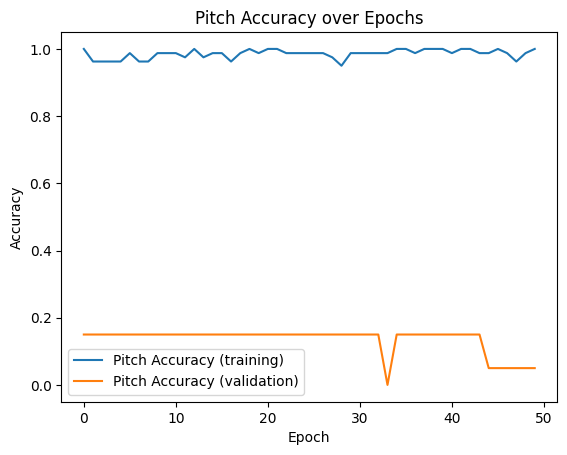

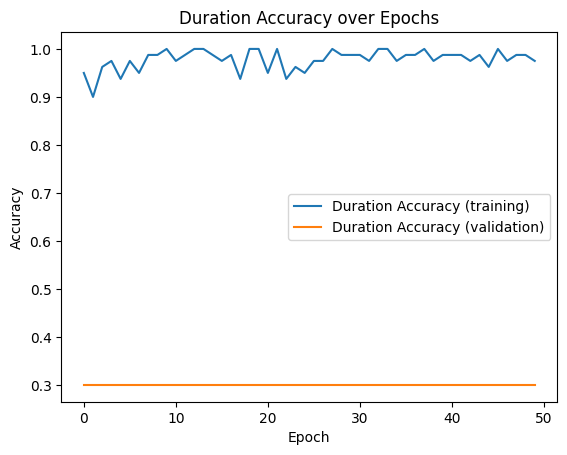

In [53]:
import matplotlib.pyplot as plt

# Plot pitch accuracy
plt.plot(history.history['pitch_output_accuracy'], label='Pitch Accuracy (training)')
plt.plot(history.history['val_pitch_output_accuracy'], label='Pitch Accuracy (validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Pitch Accuracy over Epochs')
plt.legend()
plt.show()

# Plot duration accuracy
plt.plot(history.history['duration_output_accuracy'], label='Duration Accuracy (training)')
plt.plot(history.history['val_duration_output_accuracy'], label='Duration Accuracy (validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Duration Accuracy over Epochs')
plt.legend()
plt.show()


In [54]:
# Print final loss values
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")


Final Training Loss: 0.08053852617740631
Final Validation Loss: 5.326744079589844


# Predict

In [82]:
# NEW

def predict_on_new_data(model, new_image_folder, pitch_encoder, duration_encoder, target_size=(224, 224)):
    new_images, new_filenames = load_images_and_labels(new_image_folder, None, target_size=target_size)  # Assuming labels not needed for new data

    new_images = new_images / 255.0  # Normalize the images
    new_predictions = model.predict(new_images)

    predicted_pitches = [pitch_encoder.inverse_transform(np.argmax(seq, axis=1)) for seq in new_predictions[0]]
    predicted_durations = [duration_encoder.inverse_transform(np.argmax(seq, axis=1)) for seq in new_predictions[1]]

    predicted_tuples = [list(zip(pitches, durations)) for pitches, durations in zip(predicted_pitches, predicted_durations)]

    return new_filenames, predicted_tuples

# Use the function on your test data
new_image_folder = '../raw_data/testdata/sheet_images'
new_filenames, predicted_tuples = predict_on_new_data(model, new_image_folder, pitch_encoder, duration_encoder)

# Print the results
for i, filename in enumerate(new_filenames):
    print(f"Image: {filename}")
    print(f"Predicted Tuples: {predicted_tuples[i]}")
    print("---")


ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [55]:
def load_new_images(image_folder, target_size=(224, 224)):
    images = []
    filenames = []
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        image = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB
        image = image.resize(target_size)
        image = img_to_array(image)
        images.append(image)
        filenames.append(img_name)
    return np.array(images), filenames

# Load and preprocess the new images
new_images, new_filenames = load_new_images('../raw_data/testdata/sheet_images', target_size=(224, 224))

# Normalize the images
new_images = new_images / 255.0

In [56]:
# Use the model to predict the pitch and duration
new_predictions = model.predict(new_images)

# Extract the pitch and duration predictions
predicted_pitches = np.argmax(new_predictions[0], axis=1)  # pitch_output
predicted_durations = np.argmax(new_predictions[1], axis=1)  # duration_output

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [57]:
# Decode the predictions back to their original labels
decoded_pitches = pitch_encoder.inverse_transform(predicted_pitches)
decoded_durations = duration_encoder.inverse_transform(predicted_durations)


In [58]:
# Print the predictions for each image
for i, filename in enumerate(new_filenames):
    print(f"Image: {filename}")
    print(f"Predicted Pitches: {decoded_pitches[i]}")
    print(f"Predicted Durations: {decoded_durations[i]}")
    print("---")


Image: music_8.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_9.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_7.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_6.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_4.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_5.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_1.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_0.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_2.png
Predicted Pitches: 11
Predicted Durations: 21
---
Image: music_3.png
Predicted Pitches: 11
Predicted Durations: 21
---


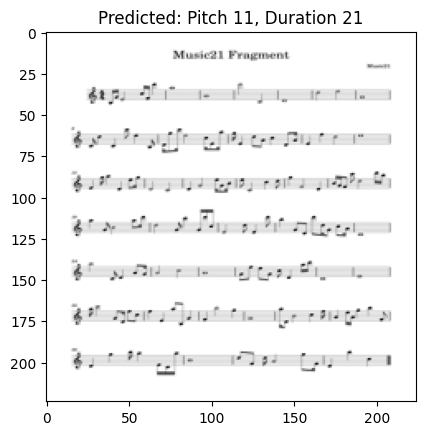

In [59]:
import matplotlib.pyplot as plt

# Visualize the first test image with its predictions
plt.imshow(new_images[0])
plt.title(f"Predicted: Pitch {decoded_pitches[0]}, Duration {decoded_durations[0]}")
plt.show()


In [74]:
# Assuming each image could have multiple notes, so the model outputs a sequence
new_predictions = model.predict(new_images)

# Assuming new_predictions[0] (for pitch) and new_predictions[1] (for duration) are 2D arrays:# Shape [batch_size, sequence_length, num_classes]# For each image, get the predicted sequence of pitches and durations
predicted_tuples = []

for i in range(len(new_filenames)):
    predicted_pitches = np.argmax(new_predictions[0][i], axis=1)  # Get pitch predictions for the i-th image
    predicted_durations = np.argmax(new_predictions[1][i], axis=1)  # Get duration predictions for the i-th image
    decoded_pitches = pitch_encoder.inverse_transform(predicted_pitches)
    decoded_durations = duration_encoder.inverse_transform(predicted_durations)

    # Combine into a list of tuples for this image
    image_tuples = [(decoded_pitches[j], decoded_durations[j]) for j in range(len(decoded_pitches))]
    predicted_tuples.append(image_tuples)

# Print the results for each imagefor i, filename inenumerate(new_filenames):
    print(f"Image: {filename}")
    print(f"Predicted Tuples: {predicted_tuples[i]}")
    print("---")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

[array([[0.02187318, 0.01978158, 0.12440104, 0.0093972 , 0.13342316,
         0.01252946, 0.06608214, 0.03773208, 0.09767182, 0.04784165,
         0.13293028, 0.1684386 , 0.03748966, 0.01239083, 0.02891434,
         0.03850703, 0.0105959 ],
        [0.022731  , 0.01995753, 0.13004866, 0.00932688, 0.13118638,
         0.01182208, 0.06667511, 0.03808972, 0.10129949, 0.04469506,
         0.13269992, 0.16802277, 0.03720666, 0.01252289, 0.02760325,
         0.03586098, 0.01025162],
        [0.02318896, 0.02029232, 0.1328785 , 0.0093025 , 0.13177463,
         0.01179872, 0.06904665, 0.03758981, 0.09862582, 0.04342681,
         0.13258903, 0.16536511, 0.03760531, 0.01261558, 0.0283773 ,
         0.03512049, 0.01040249],
        [0.02351052, 0.01917304, 0.13541368, 0.00926246, 0.13497545,
         0.01242655, 0.06806113, 0.03759798, 0.09612826, 0.04475709,
         0.13294432, 0.15972991, 0.0371876 , 0.01262897, 0.02963381,
         0.03606678, 0.01050255],
        [0.0238707 , 0.01964496, 0.1